# Going to Mars with Python using poliastro

![poliastro](https://docs.poliastro.space/en/latest/_images/logo_text.png)

## Juan Luis Cano Rodríguez <hello@juanlu.space>

### ...in 5 minutes :)

## *Warning*: This *is* rocket science!

# What is Astrodynamics?

> A branch of Mechanics (itself a branch of Physics) which studies practical problems concerning the motion of rockets and spacecraft throght space

![Rosetta's mission](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2014/10/rosetta_s_journey_and_timeline/14978088-1-eng-GB/Rosetta_s_journey_and_timeline_node_full_image_2.jpg)

# What is poliastro?

> A pure Python library for Astrodynamics

# Let's go to Mars!

Mars Science Laboratory trajectory:

![Mars Science Laboratory trajectory](msl.png)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import astropy.units as u
from astropy import time

In [2]:
# https://github.com/plotly/plotly.py/issues/1664#issuecomment-511773518
import plotly.graph_objects as go
import plotly.io as pio

# Set default renderer
pio.renderers.default = "plotly_mimetype+notebook_connected+jupyterlab"

# Set default template
pio.templates["slides"] = go.layout.Template(layout=dict(width=700, height=550))
pio.templates.default = "plotly+slides"

## Preliminaries: How to define an orbit

In [3]:
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit

r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v)
ss

7283 x 10293 km x 153.2 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)

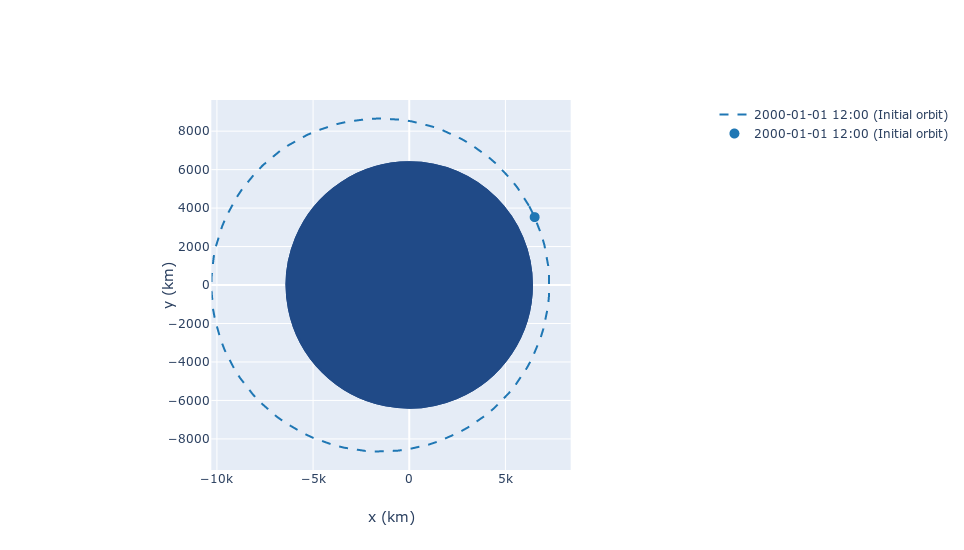

In [4]:
ss.plot(interactive=True, label="Initial orbit")

## First: locate the planets

In [5]:
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

### Earth

In [6]:
date_launch = time.Time("2011-11-26 15:02", scale="utc")

earth_launch = Orbit.from_body_ephem(Earth, date_launch)
earth_launch

1 x 1 AU x 23.4 deg (ICRS) orbit around Sun (☉) at epoch 2011-11-26 15:03:06.183 (TDB)

In [7]:
earth_launch.r

<Quantity [6.46006434e+07, 1.21424866e+08, 5.26400473e+07] km>

In [8]:
earth_launch.v

<Quantity [-2352414.27027126,  1032013.3380897 ,   447276.92493007] km / d>

### Mars

In [9]:
date_arrival = time.Time("2012-08-06 05:17", scale="utc")

tof = date_arrival - date_launch

mars_arrival = Orbit.from_body_ephem(Mars, date_arrival)
mars_arrival

1 x 2 AU x 24.7 deg (ICRS) orbit around Sun (☉) at epoch 2012-08-06 05:18:07.183 (TDB)

## Second: Compute the trajectory

In [10]:
from poliastro.maneuver import Maneuver

man_lambert = Maneuver.lambert(earth_launch, mars_arrival)

# Get the transfer orbit
ss_trans, _ = earth_launch.apply_maneuver(man_lambert, intermediate=True)
ss_trans

1 x 2 AU x 22.9 deg (HCRS) orbit around Sun (☉) at epoch 2011-11-26 15:03:06.183 (TDB)

### ...and it is pure Python!

Trick: **numba**

![Fortran and Python](benchmarks.png)

From my paper Cano Rodríguez, Juan Luis, Helge Eichhorn, and Frazer McLean: poliastro: An Astrodynamics library written in Python with Fortran performance.

## Third: Go to Mars!

In [11]:
from poliastro.plotting import OrbitPlotter3D

plotter = OrbitPlotter3D()

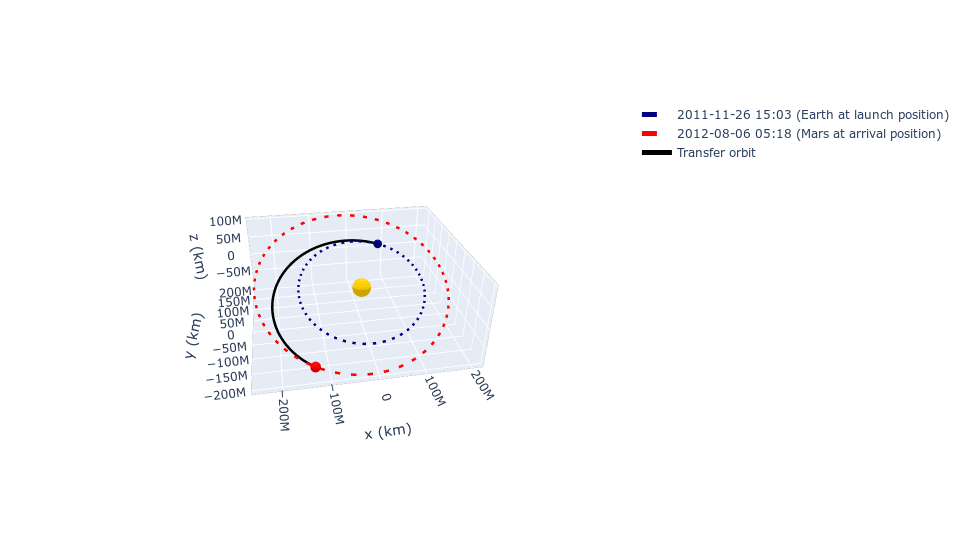

In [12]:
plotter.plot(earth_launch, label="Earth at launch position", color="navy")
plotter.plot(mars_arrival, label="Mars at arrival position", color="red")
plotter.plot_trajectory(ss_trans.sample(max_anomaly=180 * u.deg).cartesian, color="black", label="Transfer orbit")
plotter.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)

## Thank you very much!

### https://docs.poliastro.space
### <hello@juanlu.space>

![Rocket](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2012/02/liftoff_of_vega_vv014/9659852-3-eng-GB/Liftoff_of_Vega_VV01_large.jpg)

## Fourth: Make it interactive!!!1!

In [ ]:
from ipywidgets import interact, interactive, FloatSlider, VBox
from IPython.display import display

In [ ]:
# FIXME: We need to redefine the orbit plotter classes
# to leverage the batch_update
# and make the animations more seamless

from plotly.graph_objs import Layout, Scatter3d, Surface
from poliastro.plotting._base import BaseOrbitPlotter, Trajectory
from poliastro.plotting.util import generate_sphere


class CustomBaseOrbitPlotter(BaseOrbitPlotter):
    def plot_trajectory(self, trajectory, *, label=None, color=None):
        """Plots a precomputed trajectory.
        An attractor must be set first.
        Parameters
        ----------
        trajectory : ~astropy.coordinates.CartesianRepresentation
            Trajectory to plot.
        label : string, optional
        color : string, optional
        """
        if self._attractor is None:
            raise ValueError(
                "An attractor must be set up first, please use "
                "set_attractor(Major_Body) or plot(orbit)."
            )
        else:
            if color is None:
                color = next(self._color_cycle)

            trace = self._plot_trajectory(trajectory, str(label), color, False)

            self._trajectories.append(
                Trajectory(trajectory, None, label, trace.line.color)
            )

        if not self._figure._in_batch_mode:
            return self.show()

    def plot(self, orbit, *, label=None, color=None):
        """Plots state and osculating orbit in their plane.
        Parameters
        ----------
        orbit : ~poliastro.twobody.orbit.Orbit
            Orbit to plot.
        label : string, optional
            Label of the orbit.
        color : string, optional
            Color of the line and the position.
        """
        if color is None:
            color = next(self._color_cycle)

        self._set_attractor(orbit.attractor)

        label = generate_label(orbit, label)
        trajectory = orbit.sample()

        trace = self._plot_trajectory(trajectory, label, color, True)

        self._trajectories.append(
            Trajectory(trajectory, orbit.r, label, trace.line.color)
        )

        # Redraw the attractor now to compute the attractor radius
        self._redraw_attractor()

        # Plot required 2D/3D shape in the position of the body
        radius = min(
            self._attractor_radius * 0.5, (norm(orbit.r) - orbit.attractor.R) * 0.5
        )  # Arbitrary thresholds
        self._plot_point(radius, color, label, center=orbit.r)

        if not self._figure._in_batch_mode:
            return self.show()

class CustomOrbitPlotter3D(CustomBaseOrbitPlotter):
    """OrbitPlotter3D class.
    """

    def __init__(self, figure=None, dark=False):
        super().__init__(figure)
        self._layout = Layout(
            autosize=True,
            scene=dict(
                xaxis=dict(title="x (km)"),
                yaxis=dict(title="y (km)"),
                zaxis=dict(title="z (km)"),
                aspectmode="data",  # Important!
            ),
        )
        if dark:
            self._layout.template = "plotly_dark"

    def _plot_point(self, radius, color, name, center=[0, 0, 0] * u.km):
        # We use _plot_sphere here because it's not easy to specify the size of a marker
        # in data units instead of pixels, see
        # https://stackoverflow.com/q/47086547
        return self._plot_sphere(radius, color, name, center)

    def _plot_sphere(self, radius, color, name, center=[0, 0, 0] * u.km):
        xx, yy, zz = generate_sphere(radius, center)
        sphere = Surface(
            x=xx.to(u.km).value,
            y=yy.to(u.km).value,
            z=zz.to(u.km).value,
            name=name,
            colorscale=[[0, color], [1, color]],
            cauto=False,
            cmin=1,
            cmax=1,
            showscale=False,
        )
        self._figure.add_trace(sphere)

        return sphere

    def _plot_trajectory(self, trajectory, label, color, dashed):
        trace = Scatter3d(
            x=trajectory.x.to(u.km).value,
            y=trajectory.y.to(u.km).value,
            z=trajectory.z.to(u.km).value,
            name=label,
            line=dict(color=color, width=5, dash="dash" if dashed else "solid"),
            mode="lines",  # Boilerplate
        )
        self._figure.add_trace(trace)

        return trace

    @u.quantity_input(elev=u.rad, azim=u.rad, distance=u.km)
    def set_view(self, elev, azim, distance=5 * u.km):
        x = distance * np.cos(elev) * np.cos(azim)
        y = distance * np.cos(elev) * np.sin(azim)
        z = distance * np.sin(elev)

        self._layout.update(
            {
                "scene": {
                    "camera": {
                        "eye": {
                            "x": x.to(u.km).value,
                            "y": y.to(u.km).value,
                            "z": z.to(u.km).value,
                        }
                    }
                }
            }
        )

        if not self._figure._in_batch_mode:
            return self.show()

In [ ]:
fig = FigureWidget()

fig.layout.title = "MSL Mission: from Earth to Mars"
fig.layout.autosize = False
fig.layout.width = 960
fig.layout.height = 600
fig.layout.margin = dict(l=10, r=10, b=10, t=100)

In [ ]:
def go_to_mars(tof_):
    times_vector = time_range(date_launch, end=date_launch + tof_ * u.h, periods=N)

    # Solve Lambert problem with new data
    mars_arrival = Orbit.from_body_ephem(Mars, date_launch + tof_ * u.h)
    (v_launch, v_arrival), = lambert(Sun.k, earth_launch.r, mars_arrival.r, tof_ * u.h)
    ss0_trans = Orbit.from_vectors(Sun, earth_launch.r, v_launch, date_launch)

    # Plot
    rr_earth = propagate(earth_launch, times_vector - earth_launch.epoch)
    rr_mars = propagate(mars_arrival, times_vector - mars_arrival.epoch)
    rr_trans = propagate(ss0_trans, times_vector - ss0_trans.epoch)

    # FIXME: Apparently batch_update
    # does not prevent FigureWidget.add_trace to appear in steps?
    with fig.batch_update(): 
        # FIXME: Hack to animate the figure seamlessly
        # that however adds more and more invisible traces to the figure 
        for trace in fig.data:
            trace.visible = False

        frame = CustomOrbitPlotter3D(figure=fig)

        frame.set_attractor(Sun)

        frame.plot_trajectory(rr_earth, label=Earth, color="#3d4cd5")
        frame.plot_trajectory(rr_mars, label=Mars, color="#ec1f28")

        frame.plot_trajectory(rr_trans, label="MSL trajectory", color="#444444")

        frame.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)

    # Relayout the plot
    frame.show()

In [ ]:
slider = interactive(
    go_to_mars,
    tof_=FloatSlider(min=5000, value=6000, max=9000, step=250, continuous_update=False),
)

In [ ]:
VBox([slider, fig])